In [2]:
from openpiv import tools, pyprocess, validation, filters, scaling
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:

# Parameters for PIV
winsize = 32      # Interrogation window size in pixels
searchsize = 38   # Search area size in the second frame
overlap = 17      # Overlap between interrogation windows
dt = 0.02         # Time interval between frames in seconds
scaling_factor = 96.52  # Convert pixels to millimeters (adjust based on real-world measurements)

In [4]:

# Directory containing the frames
frame_dir = 'frames'
frames = sorted([f for f in os.listdir(frame_dir) if f.endswith('.png')])

In [5]:

# Initialize lists to accumulate the velocity fields
all_u = []
all_v = []
all_x = []
all_y = []

In [7]:

# Loop through the video frames pairwise (Only for first 20 frames)
for i in range(len(frames) - 180):
    frame_a_path = os.path.join(frame_dir, frames[i])
    frame_b_path = os.path.join(frame_dir, frames[i + 1])

    # Read consecutive frames
    frame_a = tools.imread(frame_a_path)
    frame_b = tools.imread(frame_b_path)

    # Compute the velocity field for this pair of frames
    u, v, sig2noise = pyprocess.extended_search_area_piv(
        frame_a.astype(np.int32),
        frame_b.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2peak',
    )

    # Get coordinates
    x, y = pyprocess.get_coordinates(
        image_size=frame_a.shape,
        search_area_size=searchsize,
        overlap=overlap,
    )

    # Validate and filter out unreliable vectors
    invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold=1.05,
    )
    u_filtered, v_filtered = filters.replace_outliers(
        u, v,
        invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )

    # Scale the velocity field
    x_scaled, y_scaled, u_scaled, v_scaled = scaling.uniform(
        x, y, u_filtered, v_filtered,
        scaling_factor=scaling_factor,
    )

    # Transform coordinates (optional, to set origin at bottom-left)
    x_final, y_final, u_final, v_final = tools.transform_coordinates(x_scaled, y_scaled, u_scaled, v_scaled)

    # Accumulate the velocity fields and coordinates
    all_u.append(u_final)
    all_v.append(v_final)
    all_x.append(x_final)
    all_y.append(y_final)

In [8]:

# Convert accumulated lists to arrays
u_combined = np.mean(np.stack(all_u), axis=0)
v_combined = np.mean(np.stack(all_v), axis=0)
x_combined = all_x[0]  # Assuming all coordinates are the same
y_combined = all_y[0]  # Assuming all coordinates are the same

In [9]:
# Save the combined velocity vector field to a file
tools.save('velocity_field_combined.txt', x_combined, y_combined, u_combined, v_combined, np.ones_like(u_combined))

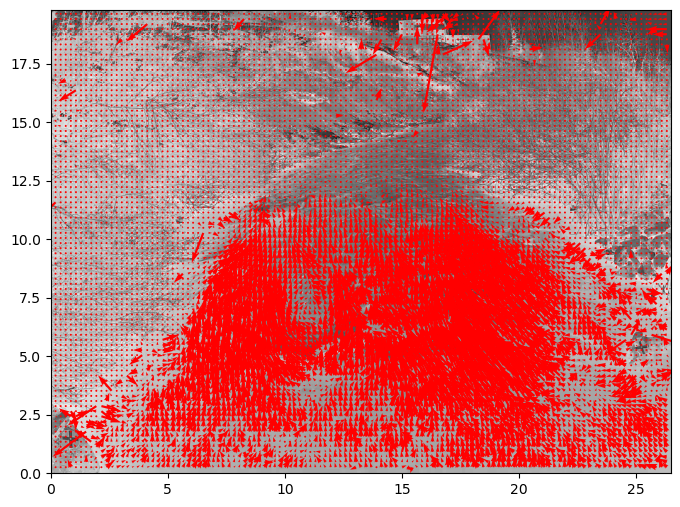

In [10]:
# Plot the combined velocity field over one of the frames
fig, ax = plt.subplots(figsize=(8, 8))
tools.display_vector_field(
    'velocity_field_combined.txt',
    ax=ax,
    scaling_factor=scaling_factor,
    scale=50,  # Defines the length of arrows
    width=0.0035,  # Thickness of arrows
    on_img=True,  # Overlay on the image
    image_name=os.path.join(frame_dir, frames[0]),  # Use the first frame as background
)
plt.show()
